# Plotting Baler Emissions
Rosie Schiffmann <br>
University of Manchester <br>
August 2025

# 1. Introduction
Inside this notebook, we will plot the estimated CO2 equivalent emissions for training Baler data compression software, and see how the training emissions vary for different numbers of epochs. The Baler compression software was trained using the example CMS data included in the Baler github repository, https://github.com/baler-collaboration/baler. Two separate methods were used to track the carbon emissions of Baler training:

- CodeCarbon (embedded software package)
- GreenAlgorithms (online calculator).

We will compare the results of these two tracking methods.

In [70]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

# 2. Data Processing

Below, we will retrieve data from CSV files labelled emissions_XXX_epochs.csv and GreenAlgorithms_results__YYYYMMDD_XXXepochs.csv, which are stored in the codecarbon_logs and greenalgorithms_logs folders repectively. XXX represents the number of epochs used for training. We will extract and average data from each file, and combine into separate dataframes for each tracking method. CodeCarbon data was collected directly from running training_baler_with_cc.py script, and metadata about the program was inputted into GreenAlgorithms online calculator to obtain the GreenAlgorithms CSV files.

In addition, data from GreenAlgorithms calculator where no usage factor was included in calculations is stored in CSV files labelled GreenAlgorithms_results__YYYYMMDD_XXXepochs_noUF.csv. This is processed in the same way as the other GreenAlgorithms data, into another separate dataframe. The usage factor represents the fractional utilisation of the CPU, and is a multiplier used in carbon emission estimation. For the GreenAlgorithms data that does utilise usage factor, the usage factor was manually calculated using CodeCarbon in cpu_load mode, by computing the average power / maximum theoretical power.

In [93]:
#process CodeCarbon output CSVs
def generate_master_cc_csv(files, tracker):
	"""
	Function to generate a master csv file containing all data for plotting for CodeCarbon output
	CSV files.

	Parameters:
	- files (list of str): list of filenames to include in master csv
	- tracker (str): "GreenAlgorithms" or "CodeCarbon"

	Returns:
	- summary_df (pandas.dataframe): contains all averaged data with propagated errors
	"""
	summary_data = []

	for file in files:
		#identify and find mean of relevant data from CodeCarbon raw outputs
		df = pd.read_csv(file)
		mean_emissions = df['emissions'].mean()
		mean_duration = df['duration'].mean()
		mean_cpu_power = df['cpu_power'].mean()
		mean_ram_power = df['ram_power'].mean()
		mean_cpu_energy = df['cpu_energy'].mean()
		mean_ram_energy = df['ram_energy'].mean()
		#obtain number of epochs from filename
		match = re.search(r'_(\d+)_epochs', file)
		epochs = int(match.group(1)) if match else None

        # Add a check to ensure epochs was found before proceeding
		if epochs is None:
			print(f"Warning: Could not extract epoch number from filename '{file}'. Skipping.")
			continue

		#propagate errors
		emissions_err = df['emissions'].std() / np.sqrt(len(df['emissions']))
		duration_err = df['duration'].std() / np.sqrt(len(df['duration']))
		cpu_power_err = df['cpu_power'].std() / np.sqrt(len(df['cpu_power']))
		ram_power_err = df['ram_power'].std() / np.sqrt(len(df['ram_power']))
		cpu_energy_err = df['cpu_energy'].std() / np.sqrt(len(df['cpu_energy']))
		ram_energy_err = df['ram_energy'].std() / np.sqrt(len(df['ram_energy']))
		
		#add dictionary of data to summary_data list 
		summary_data.append({
			'filename': file,
			'number_of_epochs': epochs,
			'mean_emissions': mean_emissions,
			'emissions_per_epoch' : mean_emissions / epochs,
			'emissions_per_epoch_err' : emissions_err / epochs,
			'emissions_err' : emissions_err,
			'mean_duration': mean_duration,
			'duration_err' : duration_err,
			'duration_per_epoch' : mean_duration / epochs,
			'duration_per_epoch_err' : duration_err / epochs,
			'mean_cpu_power': mean_cpu_power,
			'cpu_power_err' : cpu_power_err,
			'mean_ram_power' : mean_ram_power,
			'ram_power_err' : ram_power_err,
			'mean_cpu_energy' : mean_cpu_energy,
			'cpu_energy_err' : cpu_energy_err,
			'mean_ram_energy' : mean_ram_energy,
			'ram_energy_err' : ram_energy_err,
			'cpu_energy_per_epoch' : mean_cpu_energy / epochs,
			'cpu_energy_per_epoch_err' : cpu_energy_err / epochs,
			'ram_energy_per_epoch' : mean_ram_energy / epochs,
			'ram_energy_per_epoch_err' : ram_energy_err / epochs,
			'duration_per_epoch' : mean_duration / epochs,
			'duration_per_epoch_err': duration_err / epochs,
			#units: energy (kWh), power (W). *1000*3600 to get into seconds
			'cpu_energy_over_power' : 1000*3600*mean_cpu_energy / mean_cpu_power,
			'ram_energy_over_power' : 1000*3600*mean_ram_energy / mean_ram_power,
			'cpu_energy_over_power_err' : 1000*3600*(mean_cpu_energy / mean_cpu_power) * np.sqrt((cpu_energy_err/mean_cpu_energy)**2 + (cpu_power_err/mean_cpu_power)**2),
			'ram_energy_over_power_err' : 1000*3600*(mean_ram_energy / mean_ram_power) * np.sqrt((ram_energy_err/mean_ram_energy)**2 + (ram_power_err/mean_ram_power)**2)
		})

	#convert into dataframe and create master csv file.
	summary_df = pd.DataFrame(summary_data)
	summary_df.to_csv(f"{tracker}_master_emissions_data.csv", index=False)
	return summary_df

#process GreenAlgorithms output CSVs
def generate_master_ga_csv(files, tracker):
	"""
	Function to generate a master csv file containing all data for plotting, for GreenAlgorithms
	output data.

	Parameters:
	- files (list of str): list of filenames to include in master csv
	- tracker (str): "GreenAlgorithms" or "CodeCarbon"

	Returns:
	- summary_df (pandas.dataframe): contains all averaged data with propagated errors
	"""
	summary_data = []

	for file in files:
		#identify and find mean of relevant data from GreenAlgorithms raw outputs
		df = pd.read_csv(file, delimiter=';')
		mean_emissions = (df['carbonEmissions']/1000).mean() #kgCO2e
		mean_duration = (3600*df['runTime_hour'] + 60*df['runTime_min']).mean()
		#obtain number of epochs from filename
		match = re.search(r'_(\d+)epochs', file)
		epochs = int(match.group(1)) if match else None

        # Add a check to ensure epochs was found before proceeding
		if epochs is None:
			print(f"Warning: Could not extract epoch number from filename '{file}'. Skipping.")
			continue

		#propagate errors
		emissions_err = df['carbonEmissions'].std() / np.sqrt(len(df['carbonEmissions']))
		duration_err = (3600*df['runTime_hour'] + 60*df['runTime_min']).std() / np.sqrt(len(df['runTime_hour']))
		
		#add dictionary of data to summary_data list 
		summary_data.append({
			'filename': file,
			'tracker' : tracker,
			'number_of_epochs': epochs,
			'mean_emissions': mean_emissions,
			'emissions_per_epoch' : mean_emissions / epochs,
			'emissions_per_epoch_err' : emissions_err / epochs,
			'emissions_err' : emissions_err,
			'mean_duration': mean_duration,
			'duration_err' : duration_err,
			'duration_per_epoch' : mean_duration / epochs,
			'duration_per_epoch_err' : duration_err / epochs,
		})

	#convert into dataframe and create master csv file.
	summary_df = pd.DataFrame(summary_data)
	summary_df.to_csv(f"{tracker}_master_emissions_data.csv", index=False)
	return summary_df

#identify relevant csv files inside repository
cc_files = glob.glob("codecarbon_logs/emissions_*.csv")
ga_files = glob.glob("greenalgorithms_logs/GreenAlgorithms_results*epochs.csv")
ga_noUF_df = glob.glob("greenalgorithms_logs/GreenAlgorithms_results*epochs_noUF.csv")

#create dataframes and csv files
cc_summary_df = generate_master_cc_csv(cc_files, "CodeCarbon")
ga_summary_df = generate_master_ga_csv(ga_files, "GreenAlgorithms")
ga_noUF_df = generate_master_ga_csv(ga_noUF_df, "GreenAlgorithms")


# 3. Plotting Emissions

Below, we will plot the mean emissions and the emissions per epoch with respect to the number of epochs used in training. Data collected from CodeCarbon and GreenAlgorithms, and data computed with and without a usage factor, are all plotted.

In [95]:
def reduced_chi_squared(x, y, y_err, coeffs):
    """
    Calculate the reduced chi-squared for a polynomial fit.

    Parameters:
    - x: 1d array, x-values
    - y: 1d array, observed y-values
    - y_err: 1d array, uncertainties in y
    - coeffs: 1d array, polynomial coefficients from np.polyfit()

    Returns:
    - chi_squared_reduced: float
    """
    model = np.poly1d(coeffs)
    residuals = (y - model(x)) / y_err
    chi_squared = np.sum(residuals**2)
    dof = len(x) - len(coeffs)  # degrees of freedom = N - (fit order + 1)
    if dof <= 0:
        return np.nan
    return chi_squared / dof


In [100]:
def emissions_plotter(trackers, dfs, x_variable, y_variable = "mean_emissions", y_err = "emissions_err", fit=False, fit_order=None):
    """
    Creates plot of emissions vs x_variable, with optional polyfit.

    Parameters:
    - trackers: list of strings, either CodeCarbon or GreenAlgorithms. Should correspond with dfs list
    - df: list of pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable from dfs for plotting
    - y_variable: string, name of the y-axis variable from df for plotting. Should be either "mean_emissions" or 
    "emissions_per_epoch". Default = "mean_emissions"
    - y_err: string, name of the error on the y-axis variable from df for plotting. Should be either "emissions_err" or 
    "emissions_per_epoch_err". Default = "emissions_err"
    - fit: bool, whether or not a polyfit should be performed. Default=False
    - fit_order: int, order of polynomial fit if fit=True. Default=None
    """
    #validate inputs
    allowed_y_variables = ["mean_emissions", "emissions_per_epoch"]
    allowed_y_errs = ["emissions_err", "emissions_per_epoch_err"]

    if y_variable not in allowed_y_variables:
        raise ValueError(f"Invalid y_variable: '{y_variable}'. Must be one of {allowed_y_variables}.")

    if y_err not in allowed_y_errs:
        raise ValueError(f"Invalid y_err: '{y_err}'. Must be one of {allowed_y_errs}.")

    #plot emissions data
    plt.figure()
    for i in range(len(dfs)):
        plt.errorbar(dfs[i][x_variable], dfs[i][y_variable], yerr=dfs[i][y_err], fmt="x", capsize=2, label = f"{trackers[i]}")
		
		#perform polyfit if fit=True
        if fit:
			#raise error if fit=True but no fit_order is provided
            if fit_order==None:
                raise ValueError("Order of fit must be provided if fit=True.")
            
            errors_filled = dfs[i][y_err].fillna(0)
            if np.any(errors_filled == 0): #do not use error-weighted fitting if any errors=0
                coeffs = np.polyfit(dfs[i][x_variable], dfs[i][y_variable], deg=fit_order)
            else: #use error-weighted fitting
                coeffs = np.polyfit(dfs[i][x_variable], dfs[i][y_variable], deg=fit_order, w=1/dfs[i][y_err])

			#perform polyfit
            poly = np.poly1d(coeffs)
            x_fit = np.linspace(dfs[i][x_variable].min(), dfs[i][x_variable].max(), 100)
			#calculate reduced chi squared
            chi = reduced_chi_squared(dfs[i][x_variable], dfs[i][y_variable], dfs[i][y_variable], coeffs)

			#plot fit
            plt.plot(x_fit, poly(x_fit), '--', label=f"Fit (order {fit_order}). Reduced chi squared = {chi:.2g}", linewidth = 0.5)

    #set x label based on x_variable
    if x_variable=='mean_duration': plt.xlabel(f'Simulation run-time, s')
    else: plt.xlabel(f'{x_variable}')

    #plot details
    if y_variable == 'mean_emissions': 
        plt.ylabel('Emissions, kgCO2e')
        plt.title(f"Mean Emissions vs {x_variable} \n for training Baler")
    if y_variable == 'emissions_per_epoch': 
        plt.ylabel('Emissions per Epoch, kgCO2e')
        plt.title(f"Mean Emissions per Epoch vs {x_variable} \n for training Baler")
    plt.grid()
    plt.legend()
    plt.show()
    return None

/home/rosie/.cache/pypoetry/virtualenvs/baler-wrsWr4B8-py3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/home/rosie/.cache/pypoetry/virtualenvs/baler-wrsWr4B8-py3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


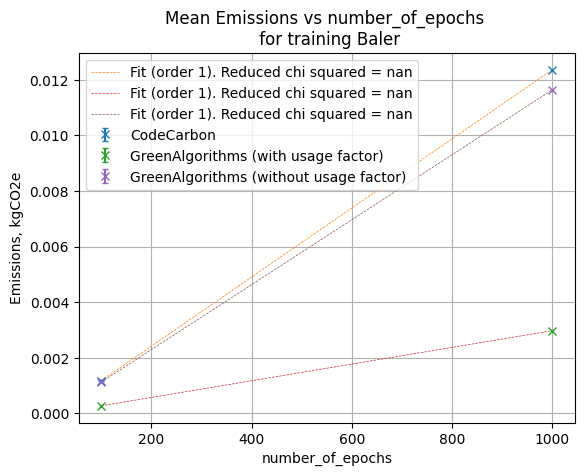

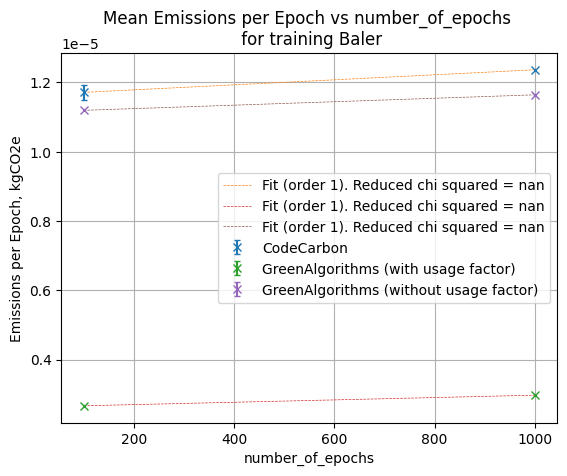

In [101]:
#plot mean emissions vs number of epochs
emissions_plotter(['CodeCarbon', 'GreenAlgorithms (with usage factor)', 'GreenAlgorithms (without usage factor)'],[cc_summary_df, ga_summary_df, ga_noUF_df], 'number_of_epochs', 'mean_emissions', 'emissions_err', True, 1)
#plot mean emissions per epoch vs number of epochs
emissions_plotter(['CodeCarbon', 'GreenAlgorithms (with usage factor)', 'GreenAlgorithms (without usage factor)'],[cc_summary_df, ga_summary_df, ga_noUF_df], 'number_of_epochs', 'emissions_per_epoch', 'emissions_per_epoch_err', True, 1)